In [1]:
import os, glob, sys, io
import pathlib

from pprint import pprint
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import scipy
import scipy.signal
import scipy.interpolate

import pickle, yaml
from tqdm.auto import tqdm, trange

from IPython.core.display import display, HTML

In [2]:
with open("dataset-info.yaml", "r") as datasetInfoFile:
    try:
        info = yaml.safe_load(datasetInfoFile)
    except yaml.YAMLError as exc:
        print(exc)
        
        
pickle_batch_root = info['pickle_batch_root']
batch_size = info['batchsize']
maskSize = info['maxsize']
data_root = os.path.join(pickle_batch_root, str(batch_size))

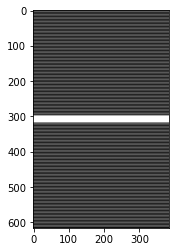

In [3]:
mask_k = np.zeros((maskSize['Ny'], maskSize['Nx']))
mask_k[::4,:] = 1

w = 10;
mask_w = np.zeros((maskSize['Ny'], maskSize['Nx']))
mask_w[maskSize['Ny']//2-w:maskSize['Ny']//2+w,:] = 1

mask_t = np.logical_or(mask_k, mask_w)

plt.imshow(mask_t, cmap='gray')#,interpolation='none')
plt.show()

In [4]:
class KSpaceGenerator(tf.keras.utils.Sequence):
    def __init__(self, pickle_root_dir, mask):
        self.filenames = glob.glob(pickle_root_dir+"/*.pickle")
        self.mask = mask
        self.data_root = pickle_root_dir
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        return self.getitem(index)
        
    def getitem(self, index):
        with open(self.filenames[index], 'rb') as f:
            padded = pickle.load(f)
        inp = padded*self.mask
        out1 = padded
        return inp, out1
    
    def get_batch_size(self):
        return int(pathlib.Path(self.data_root).stem)
    
    @staticmethod
    def transform_to_image_coils(data):
        return np.fft.fftshift(scipy.fft.fft2(data, workers=os.cpu_count()))
    @staticmethod
    def combine_coil_images(im):
        return np.sqrt(np.sum(im**2,1))
    @staticmethod
    def transform_to_images(data):
        return KSpaceGenerator.combine_coil_images(KSpaceGenerator.transform_to_image_coils(data))
   


In [5]:
kspacegen = KSpaceGenerator(data_root, mask_t)
print(len(kspacegen))
print(kspacegen.get_batch_size())

28
64


In [6]:
%time X,Y = kspacegen[1] 

Wall time: 4.68 s


Wall time: 3.8 s


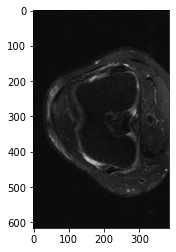

Wall time: 3.93 s


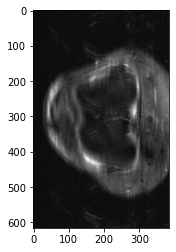

In [7]:
%time images = KSpaceGenerator.transform_to_images(Y)
plt.imshow(np.abs(images[5]), cmap='gray')
plt.show()
%time images_alias = KSpaceGenerator.transform_to_images(X)
plt.imshow(np.abs(images_alias[5]), cmap='gray')
plt.show()

In [74]:
class KSpaceCatGenerator(tf.keras.utils.Sequence):
    def __init__(self, pickle_root_dir, mask, axis, data_format="channels_first"):
        self.filenames = glob.glob(pickle_root_dir+"/*.pickle")
        self.mask = mask
        self.data_root = pickle_root_dir
        self.axis = axis
        assert(data_format in ["channels_first", "channels_last"])
        self.data_format = data_format
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        return self.getitem(index)
        
    def getitem(self, index):
        with open(self.filenames[index], 'rb') as f:
            padded = pickle.load(f)
        inp = padded*self.mask
        out1 = padded
        if self.data_format =="channels_last":
            inp = inp.transpose([0,2,3,1])
            out1 = out1.transpose([0,2,3,1])        
        inp = self.to_float(inp, self.axis)
        out1 = self.to_float(out1, self.axis)
        return inp, out1
    
    
    def get_batch_size(self):
        return int(pathlib.Path(self.data_root).stem)
    
    @staticmethod
    def to_float(X, axis):
        return np.concatenate([X.real, X.imag], axis=axis)
    @staticmethod
    def to_float(X, axis):
        return np.concatenate([X.real, X.imag], axis=axis)
    @staticmethod
    def to_complex(X, axis):
        ax = np.mod(axis, 4)
        n = X.shape[ax] // 2
        if   ax == 0: a = X[:n,:,:,:] + 1j * X[n:,:,:,:]
        elif ax == 1: a = X[:,:n,:,:] + 1j * X[:,n:,:,:]
        elif ax == 2: a = X[:,:,:n,:] + 1j * X[:,:,n:,:]
        elif ax == 3: a = X[:,:,:,:n] + 1j * X[:,:,:,n:]
        else: raise Exception("not suported axis")
        return a
        
    def transform_to_image_coils(self, data):
        axes = (-2,-1) if self.data_format == "channels_first" else (1,2)
        return np.fft.fftshift(scipy.fft.ifft2(self.to_complex(data, self.axis), axes=axes,
                                              workers=os.cpu_count()))
    def combine_coil_images(self, im):
        return np.sqrt(np.sum(im**2,1 if self.data_format == "channels_first" else 3))
    def transform_to_images(self, data):
        return self.combine_coil_images(self.transform_to_image_coils(data))
   


In [79]:
cat_axis = -1;
data_format = "channels_last"
kspacegen = KSpaceCatGenerator(data_root, mask_t, axis=cat_axis, data_format=data_format)
print(len(kspacegen))
print(kspacegen.get_batch_size())
print(kspacegen.data_format)

28
64
channels_last


In [80]:
%time X,Y = kspacegen[0] 
Y.shape

Wall time: 3.25 s


(64, 616, 384, 30)

Wall time: 6.86 s


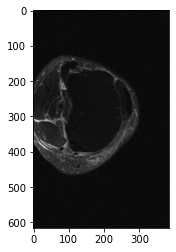

Wall time: 6.86 s


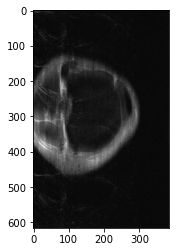

In [81]:
%time images = kspacegen.transform_to_images(Y)
plt.imshow(np.abs(images[5]), cmap='gray')
plt.show()
%time images_alias = kspacegen.transform_to_images(X)
plt.imshow(np.abs(images_alias[5]), cmap='gray')
plt.show()